In [ ]:
# 2023-08
# solving a metal cube-and-ring puzzle
# that a neighbor brought over
# fun exercise in right-hand rule and sign conventions

In [44]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [35]:
def L2(vec):
    return np.sum(vec**2)

In [36]:
# states are of two kinds:
# (edge center, orientation vector) and 
# (face vector,)

# notches are of the form:
# (edge center, notch vector)

# coords: (at me, right, up)

NOTCHES = [(np.array(u), np.array(v)) for (u, v) in [
    ([1, -1, 0], [0, 1, 0]),
    ([0, -1, 1], [0, 0, -1]),
    ([0, 1, 1], [0, -1, 0]),
    ([0, 1, -1], [0, 1, 0]),
    ([0, -1, -1], [0, -1, 0]),
    ([-1, -1, 0], [0, 1, 0]),
    ([-1, 1, 0], [0, -1, 0])
]]

STATES = []

for x in [-1, 0, 1]:
    for y in [-1, 0, 1]:
        for z in [-1, 0, 1]:
            edge = np.array([x, y, z])
            if L2(edge) == 2:
                orient = np.array([1, 1, 1]) - edge**2
                STATES.append((edge, +orient))
                STATES.append((edge, -orient))
                
for axis in range(3):
    face = np.array([0, 0, 0])
    face[axis] = 1
    
    STATES.append((+face,))
    STATES.append((-face,))

In [48]:
def is_free(state):
    if len(state) == 1:
        return False
    
    for notch in NOTCHES:
        if L2(notch[0] - state[0]) == 0:
            # notch pointing inwards
            if L2(notch[0] + notch[1]) == 1:
                face = notch[0] + notch[1]
                tooth = np.cross(state[1], face - state[0])
                
                # want tooth pointing IN
                if L2(face + tooth) == 0:
                    return True
            # notch pointing outwards
            else:
                assert L2(notch[0] + notch[1]) == 5
                
                # face OPPOSITE notch
                face = notch[0] - notch[1]
                tooth = np.cross(state[1], face - state[0])
                
                # want tooth pointing OUT
                if L2(face - tooth) == 0:
                    return True
    
    return False

def is_start(state):
    return (len(state) == 2 
            and L2(state[0] - np.array([1, 0, -1])) == 0)

In [58]:
def adjacent(edge1, edge2):
    # edge positions are adjacent
    # iff they are dist sqrt(2) apart
    return L2(edge1 - edge2) == 2

def turnable(state1, state2):
    # corners pointed to from state edge + orientation
    corner1 = state1[0] + state1[1]
    corner2 = state2[0] + state2[1]
    
    # orientation arrow will flow along turn
    # iff the corners are dist 2 apart
    return L2(corner1 - corner2) == 4
    
def is_move22_directed(state1, state2, notch):
    # check that state, state, notch form a triangle
    # at some corner
    if not (adjacent(state1[0], state2[0])
        and adjacent(state1[0], notch[0])
        and adjacent(state2[0], notch[0])):
        return False
    
    # put ring gap in the face between state and notch
    # lame hack: adj state and notch share one nonzero coord
    # so multiply them to get face, w/ sign from state1
    face = state1[0] * notch[0]**2
    
    # tooth is pointing in this direction when in the face
    # (right-hand rule)
    tooth = np.cross(state1[1], face - state1[0])
    
    assert np.dot(face, tooth) in {-1, 1}
    
    # check that notch is aimed at tooth
    # and new state is oriented correctly
    return ((L2(tooth + notch[1]) == 0) 
            and turnable(state1, state2))

def is_move(state1, state2, notch):
    # two single-edge states: corner turn
    if {len(state1), len(state2)} == {2, 2}:
        # check push-then-turn and turn-then-push
        return (is_move22_directed(state1, state2, notch)
                or is_move22_directed(state2, state1, notch))
    
    # single and double: simple push/unpush
    elif {len(state1), len(state2)} == {1, 2}:
        # single-edge, double-edge
        stateS, stateD = (state1, state2) if len(state1) == 2 else (state2, state1)
        
        # check distance from edge to notch is 2
        if L2(notch[0] - stateS[0]) != 4:
            return False
        
        # face to traverse is directly between them
        face = (notch[0] + stateS[0]) // 2

        # tooth is pointing in this direction when in the face
        # (right-hand rule)
        tooth = np.cross(stateS[1], face - stateS[0])
        
        assert np.dot(face, tooth) in {-1, 1}

        # check that notch is aimed at tooth
        if L2(tooth + notch[1]) != 0:
            return False

        # check that new state is correct 
        newface_abs = (notch[0] - stateS[0]) // 2
        # orientation: borrow from face and tooth
        newface = newface_abs * np.dot(face, tooth)
        
        return L2(newface - stateD[0]) == 0
    
    else:
        return False
    
def is_movable(state1, state2):
    return any(is_move(state1, state2, notch) for notch in NOTCHES)

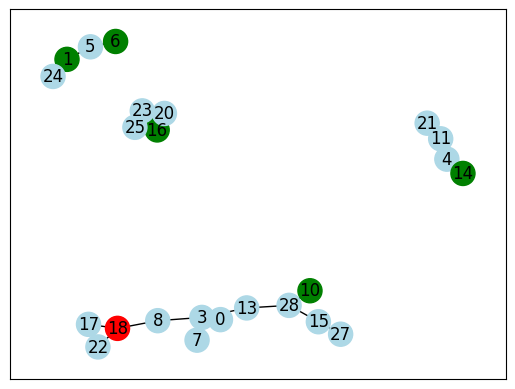

In [90]:
graph_edges = []
for i1, state1 in enumerate(STATES):
    for i2, state2 in enumerate(STATES):
        if is_movable(state1, state2):
            graph_edges.append([i1, i2])

def my_color(state):
    if is_start(state):
        return 'red'
    elif is_free(state):
        return 'green'
    else:
        return 'lightblue'
    
states_in_order = []
for e in graph_edges:
    for i in e:
        if i not in states_in_order:
            states_in_order.append(i)

colors = [my_color(STATES[i]) for i in states_in_order]
G = nx.Graph()
G.add_edges_from(graph_edges)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, font_size=12, node_color=colors)
plt.show()

In [88]:
{i:STATES[i] for i in range(len(STATES))}

{0: (array([-1, -1,  0]), array([0, 0, 1])),
 1: (array([-1, -1,  0]), array([ 0,  0, -1])),
 2: (array([-1,  0, -1]), array([0, 1, 0])),
 3: (array([-1,  0, -1]), array([ 0, -1,  0])),
 4: (array([-1,  0,  1]), array([0, 1, 0])),
 5: (array([-1,  0,  1]), array([ 0, -1,  0])),
 6: (array([-1,  1,  0]), array([0, 0, 1])),
 7: (array([-1,  1,  0]), array([ 0,  0, -1])),
 8: (array([ 0, -1, -1]), array([1, 0, 0])),
 9: (array([ 0, -1, -1]), array([-1,  0,  0])),
 10: (array([ 0, -1,  1]), array([1, 0, 0])),
 11: (array([ 0, -1,  1]), array([-1,  0,  0])),
 12: (array([ 0,  1, -1]), array([1, 0, 0])),
 13: (array([ 0,  1, -1]), array([-1,  0,  0])),
 14: (array([0, 1, 1]), array([1, 0, 0])),
 15: (array([0, 1, 1]), array([-1,  0,  0])),
 16: (array([ 1, -1,  0]), array([0, 0, 1])),
 17: (array([ 1, -1,  0]), array([ 0,  0, -1])),
 18: (array([ 1,  0, -1]), array([0, 1, 0])),
 19: (array([ 1,  0, -1]), array([ 0, -1,  0])),
 20: (array([1, 0, 1]), array([0, 1, 0])),
 21: (array([1, 0, 1]),

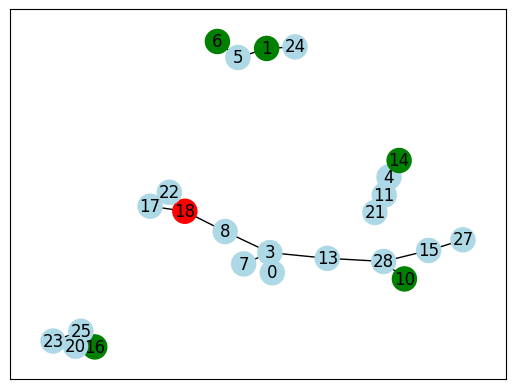

In [84]:
path = [18, 8, 3, 13, 28, 10]

for i in range(len(path) - 1):
    #print(path[i], STATES[i])
    print([notch for notch in NOTCHES if is_move(STATES[path[i]], STATES[path[i+1]], notch)])
    #print(path[i+1], STATES[i+1])
    #print()

[(array([ 1, -1,  0]), array([0, 1, 0]))]
[(array([-1, -1,  0]), array([0, 1, 0]))]
[(array([-1,  1,  0]), array([ 0, -1,  0]))]
[(array([0, 1, 1]), array([ 0, -1,  0]))]
[(array([ 0, -1, -1]), array([ 0, -1,  0]))]
